## Fraud Model
This notebook:
1. demonstrates the distribution of two fraud probabilities
2. converts categorical data into continuous data
3. splits transactions with given fraud probabilities into training and validation set
4. fits a logistic regression model on training set and evaluates on validation set

In [9]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import pandas as pd
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline 
from pyspark.ml.feature import VectorAssembler 
from pyspark.ml.feature import OneHotEncoder
from pyspark.sql.functions import rand
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

In [3]:
# Create a spark session (which will run spark jobs)
spark = (
    SparkSession.builder.appName("MAST30034 Project 2")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.driver.memory", "2g")
    .config("spark.executer.memory", "4g")
    .getOrCreate()
)

## Visualisation
Examine the distribution of both delta files.

In [4]:
# read delta files
merchant_df = pd.read_csv("../data/tables/merchant_fraud_probability.csv")
consumer_df = pd.read_csv("../data/tables/consumer_fraud_probability.csv")

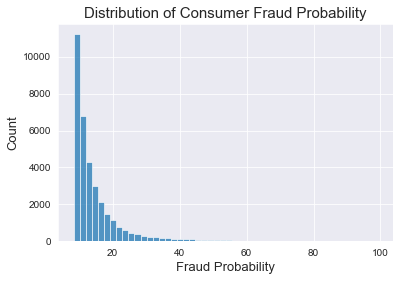

In [25]:
# distribution plot of consumer fraud probability
sns.histplot(consumer_df["fraud_probability"], bins=50)
plt.title("Distribution of Consumer Fraud Probability", fontsize=15)
plt.xlabel("Fraud Probability", fontsize=13)
plt.ylabel("Count", fontsize=13)
plt.savefig("../plots/Distribution of Consumer Fraud Probability.png")
plt.show()

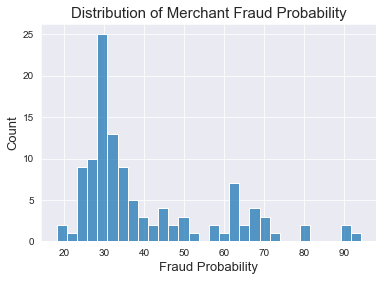

In [26]:
# distribution plot of merchant fraud probability
sns.histplot(merchant_df["fraud_probability"], bins=30)
plt.title("Distribution of Merchant Fraud Probability", fontsize=15)
plt.xlabel("Fraud Probability", fontsize=13)
plt.ylabel("Count", fontsize=13)
plt.savefig("../plots/Distribution of Merchant Fraud Probability.png")
plt.show()

## Preprocessing

In [20]:
full = spark.read.parquet("../data/curated/full_data/")
probs_merchant = spark.read.option('header', True).csv('../data/tables/merchant_fraud_probability.csv')
probs_consumer= spark.read.option('header', True).csv('../data/tables/consumer_fraud_probability.csv')
full.printSchema()

root
 |-- user_id: long (nullable = true)
 |-- SA2_code: integer (nullable = true)
 |-- postcode: integer (nullable = true)
 |-- consumer_id: integer (nullable = true)
 |-- state: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- mean_total_income: integer (nullable = true)
 |-- merchant_abn: long (nullable = true)
 |-- dollar_value: double (nullable = true)
 |-- order_id: string (nullable = true)
 |-- order_datetime: date (nullable = true)
 |-- name: string (nullable = true)
 |-- tags: string (nullable = true)
 |-- revenue_level: string (nullable = true)
 |-- take_rate: double (nullable = true)



In [22]:
# convert features to appropriate data types
probs_consumer =  probs_consumer.withColumn('user_id', F.col('user_id').cast('long'))\
                                .withColumn('fraud_probability', F.col('fraud_probability').cast('float'))
probs_merchant =  probs_merchant.withColumn('merchant_abn', F.col('merchant_abn').cast('long'))\
                                .withColumn('fraud_probability', F.col('fraud_probability').cast('float'))

# merge transaction file with merchants'/consumers' fraud probability based on merchant abn or user id respectively by left join
full = full.join(probs_merchant, on = ['merchant_abn', 'order_datetime'], how = 'left').withColumnRenamed('fraud_probability', 'merchant_prob')
full = full.join(probs_consumer, on = ['user_id', 'order_datetime'], how = 'left').withColumnRenamed('fraud_probability', 'consumer_prob')

In [23]:
# replace all the missing value with 0.01 as default fraud prob
full = full.na.fill(value=0.01, subset=['merchant_prob', 'consumer_prob'])

# set benchmark as 5% to focus on False Positive instead of False Negative
full = full.withColumn('is_fraud', F.when((F.col('merchant_prob') > 5) | (F.col('consumer_prob') > 5), 1).otherwise(0))

# discard extremely small values
full = full.filter(F.col('dollar_value') >= 1).na.drop(subset = 'name')
full =  full.withColumn('month', F.month('order_datetime'))

In [24]:
print('In {} transactions, {} are detected as fraud'.format(full.count(), full.filter(F.col('is_fraud') == 1).count()))

In 13504142 transactions, 75108 are detected as fraud


## Feature Engineering

### Index ordinal features & one hot encoding

In [14]:
full =  full.withColumn('month', F.month('order_datetime'))

In [21]:
indexed_features = ['revenue_level', 'tags', 'gender']
indexers =[]
for col in indexed_features:
    indexers.append(StringIndexer(inputCol=col, outputCol = col+"_index"))

# one-hot encode the numeric indices
categorical_features =  ["tags_index", "gender_index","month"]
ohe = []
for f in categorical_features:
    ohe.append(OneHotEncoder(inputCol=f, outputCol=f+"OHE"))

pipeline = Pipeline(stages=indexers+ohe)
indexed_result = pipeline.fit(full).transform(full)

### Feature Selection and Vectorization

In [ ]:
feature_selected = ['dollar_value','take_rate','mean_total_income','monthOHE','revenue_level_index','tags_indexOHE','gender_indexOHE']
assembler = VectorAssembler(inputCols=feature_selected ,outputCol='features')
processed_data = assembler.transform(indexed_result)

### Train Test Split

In [33]:
# imbalanced distribution of two classes. We decide to split the data according to their class and make the distribution balanced
fraud_data = processed_data.filter(F.col('is_fraud') == 1)
normal_data = processed_data.filter(F.col('is_fraud') == 0).randomSplit([0.01,0.99], 0)[0]

In [34]:
# train/test split
train_fraud,test_fraud = fraud_data.randomSplit([0.7,0.3])
train_normal,test_normal = normal_data.randomSplit([0.7,0.3])
train_data = train_fraud.union(train_normal).orderBy(rand())
test_data = test_fraud.union(test_normal).orderBy(rand())

In [37]:
train_data.count(),test_data.count()

(106409, 45855)

## Modelling (Logistic Regression)

In [38]:
lr = LogisticRegression(labelCol='is_fraud')
fitted_model = lr.fit(train_data)
fitted_model.setFeaturesCol("features")
fitted_model.setPredictionCol("prediction")

In [40]:
# evaluate model performance
pred_and_labels = fitted_model.evaluate(test_data)
score_and_label = pred_and_labels.predictions.select('prediction', 'is_fraud').withColumnRenamed('is_fraud', 'label')
evaluator = MulticlassClassificationEvaluator()
evaluator.setPredictionCol("prediction")

In [45]:
# display evaluation metrics
print("Accuracy: " + str(evaluator.evaluate(score_and_label)))
tp = score_and_label.filter((F.col('prediction') == 1) & (F.col('label') == 1)).count()
fn = score_and_label.filter((F.col('prediction') == 0) & (F.col('label') == 1)).count()
recall = tp/(tp+fn)
print('recall: ' + str(recall))

## 